In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
import os
import time
import pickle
import numpy as np
from matplotlib import pyplot as plt

# Functions

In [2]:

# rm saved_models/Transformers/ReverseTask/ -rf

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth


def compute_avg(results):
    # compute the averages 
    results_avg = {}

    for key, _ in results.keys():
        results_avg[key] = {}

    for key in results.keys():
          for x,y in results[key].items():
              # import pdb; pdb.set_trace()
              if x in results_avg[key[0]]:
                results_avg[key[0]][x] += np.array(y)
              else: 
                results_avg[key[0]][x] = np.array(y)
        
    # num_runs = len(results.keys())//3
    num_runs =  max(j for i,j in list(results.keys()) if i=='kv') + 1
    # compute the avg
    for key,val in results_avg.items():
          for x, y in val.items():
              y = np.array(y)
              results_avg[key][x] = y / num_runs

    results_avg = {k: results_avg[k] for k in desired_order_list if k in results_avg}                
    return results_avg


def compute_grand_avg(grand_res):

    from copy import deepcopy

    grand_res_avg = deepcopy(grand_res[0])

    for y in grand_res[1:]:
      for norm in y:
          for k,v in y[norm].items():
            grand_res_avg[norm][k] += v


    for norm in grand_res_avg:
        for k,v in grand_res_avg[norm].items():
          grand_res_avg[norm][k] /= len(grand_res)

        
    grand_res_avg = {k: grand_res_avg[k] for k in desired_order_list if k in grand_res_avg}                    
        
    # compute std for accs
    acc_k = config[which_db]['acc_key']
    if acc_k is None:
        return grand_res_avg, None
    
    res = {}
    for norm in grand_res[0].keys():
        accs = [y[norm][acc_k] for y in grand_res]
        res[norm] = [np.mean(accs), np.std(accs)]
            
    res = {k: res[k] for k in desired_order_list if k in res}
    
    return grand_res_avg, res


In [3]:
def do_plot(results_avg):

    fig, axs = plt.subplots(1,2) #, sharex=True, sharey=True)

    # results_avg = {k: results_avg[k] for k in desired_order_list if k in results_avg}    

    idx = 0
    for key in results_avg.keys():
          t_time = results_avg[key]['time_spent'] 
          box_size = config[which_db]['smooth_factor_train'] 
          zz = results_avg[key]['train_loss_history']
          tt = np.log10(zz) if log_plot else zz
          ss = smooth(tt,box_size)[box_size:-box_size]

          axs[0].plot(t_time[box_size:-box_size], ss, color_dict[key], lw=2)
          axs[0].grid('on')

          axs[0].set(title='train', xlabel='Training time (sec)', ylabel='Loss (log 10)' if log_plot else 'Loss')


          idx += 1



    idx = 0
    for key in results_avg.keys():
          jj = '' if which_db == 'gpt' else config[which_db]['key_name']+'_'
          t_time = results_avg[key][f'{jj}time_spent'] 
          box_size = config[which_db]['smooth_factor_val']           
          xx = config[which_db]['key_name']
          zz = results_avg[key][f'{xx}_loss_history']
          tt = np.log10(zz) if log_plot else zz
          ss = smooth(tt,box_size)[box_size:-box_size]

          axs[1].plot(t_time[box_size:-box_size], ss, color_dict[key], lw=2)
          axs[1].grid('on')

          axs[1].set(title='val', xlabel='Training time (sec)')
          
          leg = list(results_avg.keys())
          if 'sqrt' in leg:
              leg[leg.index('sqrt')] = 'qkv'
          leg = [map_key_names[l] for l in leg]    
          axs[1].legend(leg) 

          idx += 1


    fig.tight_layout()
    plt.show()

# fig.savefig(f'drive/MyDrive/KV_Transformer_Res/{d_dim}_{d_depth}_{h_heads}_{num_epochs}_{lr}_{sequence_length}_{which_task}_avg.png', dpi=150, format="png")


def do_plot_all(results):
    fig, axs = plt.subplots(1,2, figsize=(10,7)) #, sharex=True, sharey=True)

    idx = 0
    for key, c in results.keys():
          t_time = results[(key, c)]['time_spent'] 
          box_size = smooth_factor_train 
          tt = results[(key, c)]['train_loss_history']
          ss = smooth(tt,box_size)[box_size:-box_size]

          axs[0].plot(t_time[box_size:-box_size], ss, colors[idx//num_runs], lw=3)
          axs[0].grid('on')

          axs[0].set(title='train', xlabel='Training time (sec)', ylabel= 'Loss (log 10)' if log_plot else 'Loss')

          idx += 1



    idx = 0
    for key, c in results.keys():
          t_time = results[(key, c)]['val_time_spent'] 
          box_size = smooth_factor_val 
          tt = results[(key, c)]['val_loss_history']
          ss = smooth(tt,box_size)[box_size:-box_size]      

          axs[1].plot(t_time[box_size:-box_size], ss, colors[idx//num_runs], lw=3)
          axs[1].grid('on')

          axs[1].set(title='val', xlabel='Training time (sec)')
          leg = list(results_avg.keys())
          if 'sqrt' in leg:
              leg[leg.index('sqrt')] = 'qkv'
          leg = [map_key_names[l] for l in leg]    
          axs[1].legend(leg) 

          idx += 1


    fig.tight_layout()
    plt.show()


    # fig.savefig(f'drive/MyDrive/KV_Transformer_Res/{d_dim}_{d_depth}_{h_heads}_{num_epochs}_{lr}_{sequence_length}_{which_task}_all.png', dpi=150, format="png")


def plot_acc(results_avg):

  # colors = ['g-.', 'b:', 'k']

  fig = plt.figure(figsize=(2,3))

  accs = []
  for (key,val), c in zip(results_avg.items(), colors):
      if np.max(results_avg[key][config[which_db]['acc_key']]) <=1: 
          accs.append(results_avg[key][config[which_db]['acc_key']]*100)
      else:
          accs.append(results_avg[key][config[which_db]['acc_key']])
        

    
  bars = plt.bar(np.arange(len(accs)), accs)
  plt.xticks(np.arange(len(accs)), list(results_avg.keys()), rotation=90)

  # for bar,c in zip(bars, colors):
  #   bar.set_color(c)

  fig.gca().yaxis.grid(True, zorder=0,)
  plt.ylabel('Acc (%)')
  plt.ylim(0,100)
  plt.show()

  



  # fig.savefig(f'drive/MyDrive/KV_Transformer_Res/{d_dim}_{d_depth}_{h_heads}_{num_epochs}_{lr}_{sequence_length}_{which_task}_acc.png', dpi=150, format="png")    

# Main part

reverse
19


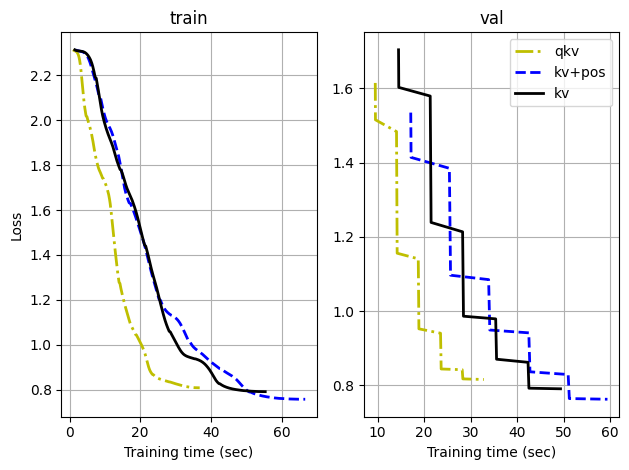

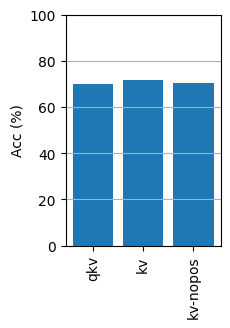

qkv & 0.6978 (0.38) 
 
kv & 0.7181 (0.35) 
 
kv-nopos & 0.7046 (0.37) 
 
0.71
sort
19


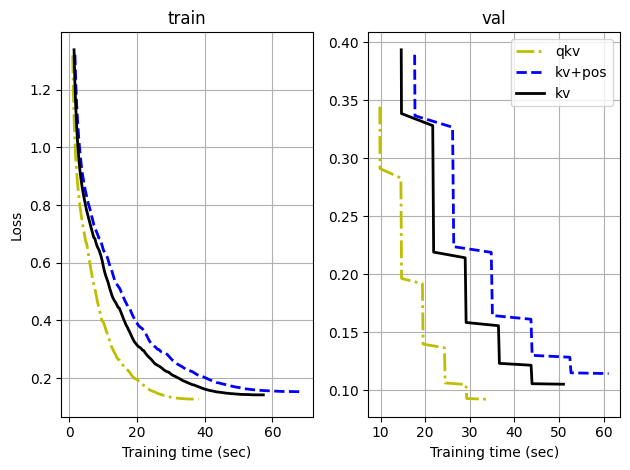

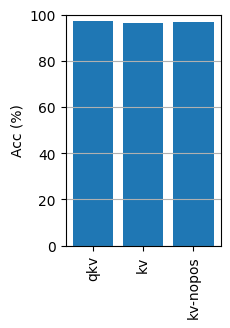

qkv & 0.9708 (0.033) 
 
kv & 0.9628 (0.038) 
 
kv-nopos & 0.9664 (0.035) 
 
0.97
copy
16


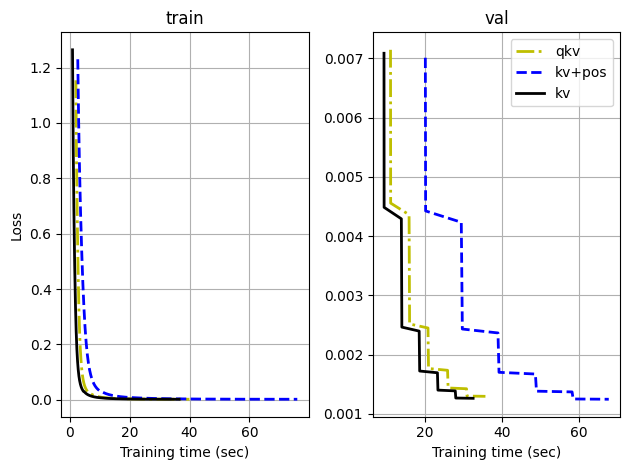

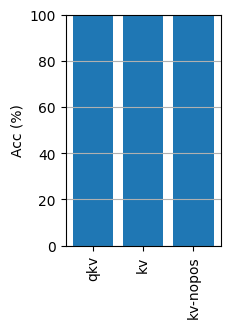

qkv & 1.0 (0.0) 
 
kv & 1.0 (0.0) 
 
kv-nopos & 1.0 (0.0) 
 
1.0
swap
16


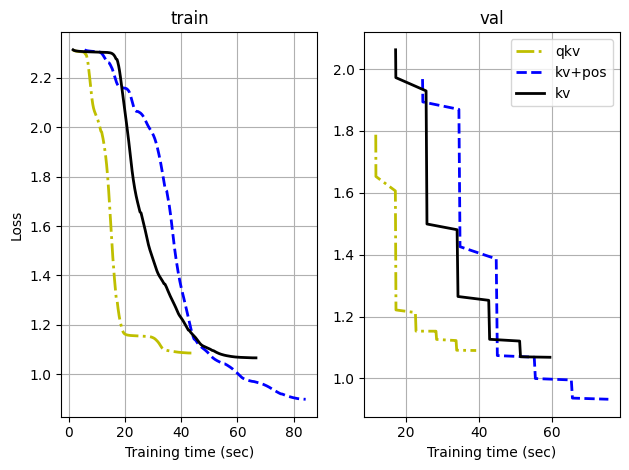

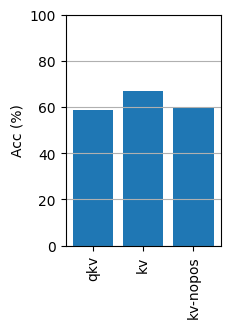

qkv & 0.588 (0.42) 
 
kv & 0.6711 (0.37) 
 
kv-nopos & 0.5974 (0.41) 
 
0.62
sub
16


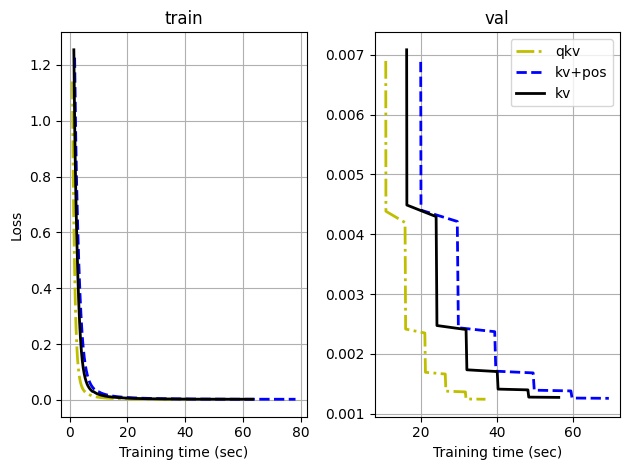

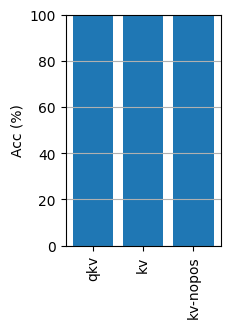

qkv & 1.0 (0.0) 
 
kv & 1.0 (0.0) 
 
kv-nopos & 1.0 (0.0) 
 
1.0


In [14]:
show_plt = 0
log_plot = 0

# colors = ['y-.', 'b:', 'k', 'c', 'k--', 'r', 'r--', 'b--']
colors = ['y-.', 'b--', 'k', 'c', 'k--', 'r', 'r--']
# desired_order_list = ['L2','sqrt','std', 'layernorm']#, 'no-sm-sqrt', 'no-sm-std', 'no-sm-layernorm']
desired_order_list = ['kv','sqrt']#, 'no-sm-sqrt', 'no-sm-std', 'no-sm-layernorm']
color_dict  = dict(zip(desired_order_list,colors))

map_key_names = {'qkv':'qkv', 'kv':'kv+pos', 'kv-nopos':'kv'}


# ---------------------- synthetics ----------------------
DBS = ['reverse', 'sort', 'copy', 'swap', 'sub']
desired_order_list = ['qkv', 'kv', 'kv-nopos']
color_dict  = dict(zip(desired_order_list,colors))
source_folder = './results_new/synthetic/'
which_db_add_legend = DBS[-1]

# # ---------------------- vision ----------------------
# DBS = ['_mnist', '_fashionmnist', 'cifar10.', 'cifar100.', 'anomaly']
# # DBS = ['anomaly']
# desired_order_list = ['sqrt', 'kv', 'kv-nopos']
# color_dict  = dict(zip(desired_order_list,colors))
# # which_db_add_legend = DBS[0]
# source_folder = './results_new/vision/'

# # ---------------------- NLP ----------------------
# DBS = ['gpt'] #, 'translation_task', '']
# desired_order_list = ['qkv', 'kv', 'kv-nopos']
# color_dict  = dict(zip(desired_order_list,colors))
# which_db_add_legend = DBS[0]
# source_folder = './results_new/nlp/'

# # # ---------------------- NLP ----------------------
# DBS = ['translation_de_en', 'translation_en_de'] #, 'translation_task', '']
# desired_order_list = ['kv', 'kv-nopos', 'qkv']
# color_dict  = dict(zip(desired_order_list,colors))
# # which_db_add_legend = 'translation_de_en'
# # source_folder = './results/nlp/'
# source_folder = './results_new/nlp/'



config = {
'reverse': {'smooth_factor_train':15, 'smooth_factor_val':15, 'key_name':'val', 'acc_key': 'test_acc'},        
'sub': {'smooth_factor_train':15, 'smooth_factor_val':15, 'key_name':'val', 'acc_key': 'test_acc'},        
'sort': {'smooth_factor_train':15, 'smooth_factor_val':15, 'key_name':'val', 'acc_key': 'test_acc'},        
'swap': {'smooth_factor_train':15, 'smooth_factor_val':15, 'key_name':'val', 'acc_key': 'test_acc'},        
'copy': {'smooth_factor_train':15, 'smooth_factor_val':15, 'key_name':'val', 'acc_key': 'test_acc'},            
'_mnist': {'smooth_factor_train':500, 'smooth_factor_val':100, 'key_name':'val', 'acc_key': 'test_acc'},    
'_fashionmnist': {'smooth_factor_train':500, 'smooth_factor_val':100, 'key_name':'val', 'acc_key': 'test_acc'},
'cifar10.': {'smooth_factor_train':700, 'smooth_factor_val':500, 'key_name':'val', 'acc_key': 'test_acc'},
'cifar100.': {'smooth_factor_train':700, 'smooth_factor_val':500, 'key_name':'val', 'acc_key': 'test_acc'},    
'anomaly': {'smooth_factor_train':500, 'smooth_factor_val':500, 'key_name':'val', 'acc_key': 'test_acc'},
'numbers': {'smooth_factor_train':200, 'smooth_factor_val':200, 'key_name':'val', 'acc_key': 'acc_history'},        
'gpt': {'smooth_factor_train':1, 'smooth_factor_val':1, 'key_name':'test', 'acc_key': None},    
'translation_de_en': {'smooth_factor_train':1, 'smooth_factor_val':1, 'key_name':'val', 'acc_key': 'test_acc'},    
'translation_en_de': {'smooth_factor_train':1, 'smooth_factor_val':1, 'key_name':'val', 'acc_key': 'test_acc'}        
}




accs_res = np.zeros((len(desired_order_list), len(DBS)))



files = os.listdir(source_folder)
files.sort()





for which_db in DBS:

    if which_db == 'anomaly':
        desired_order_list = ['qkv', 'kv', 'kv-nopos']
        color_dict  = dict(zip(desired_order_list,colors))    
    
    print(which_db)

    
    grand_res = []

    for f in files:
      # print(f)
    
      # if not f.endswith('.pkl') or f.startswith('512')  or which_db not in f: continue
      if not f.endswith('.pkl') or which_db not in f: continue

      with open(f'{source_folder}/{f}', 'rb') as g:
          results = pickle.load(g)
      
      # import pdb; pdb.set_trace()   
      # some modification for translation
      if 'translation' in which_db:
            for k,v in results.items():
                v['time_spent'] = np.cumsum(v['time_spent'])
                v['val_time_spent'] = np.cumsum(v['val_time_spent'])
         
        
      # print(results.keys())
            
      grand_res.append(compute_avg(results))

      
      if show_plt:  
          print(f)
          do_plot(compute_avg(results))  


    print(len(grand_res))


    grand_res_avg, res_acc = compute_grand_avg(grand_res)
    do_plot(grand_res_avg)
    

    
    if not res_acc: continue    
    
    plot_acc(grand_res_avg)
    
    x = []
    for i,(m,s) in res_acc.items():
        print(f'{i} & {m:3.4} ({s:3.2}) \n ')
        x.append(m)
    print(f'{np.mean(x):3.2}')
    

    accs_res[:,DBS.index(which_db)] = np.array(x)
    

In [5]:
results[('kv', 0)]

{'time_spent': [2.429320812225342,
  6.739947080612183,
  11.021318435668945,
  15.301215171813965,
  19.565826892852783,
  23.865971326828003,
  28.117332458496094,
  32.377562522888184,
  36.635693311691284,
  40.972492933273315,
  45.261197566986084,
  49.5072226524353,
  53.777650594711304,
  58.02485489845276,
  62.37654685974121,
  66.74114322662354,
  71.14817476272583,
  75.67902660369873,
  79.88920831680298,
  84.20834136009216,
  88.49276852607727,
  92.96220588684082,
  97.27837204933167,
  101.77230834960938,
  106.21382594108582,
  110.55776619911194,
  114.8761637210846,
  119.2555034160614,
  123.79969263076782,
  128.4488046169281,
  132.87604355812073,
  137.23995733261108,
  141.55237340927124,
  146.40762209892273,
  150.92448234558105,
  155.7985281944275,
  160.52265977859497,
  165.2111508846283,
  169.64895391464233,
  174.40864825248718,
  178.94571590423584,
  183.38846039772034,
  188.14138174057007,
  192.65029287338257,
  197.20613551139832,
  201.753366708

In [6]:
results.keys()

dict_keys([('kv', 0), ('kv', 1), ('qkv', 0), ('qkv', 1), ('kv-nopos', 0), ('kv-nopos', 1)])

In [ ]:
print(accs_res)
print(accs_res.mean(axis=1))

for x in accs_res.mean(axis=1):
    print(f'{x:3.2} & ', end='\n')

# print(accs_res)

# DBS.index('sub')

In [170]:
# for x in grand_res:
#   do_plot(x)
#   plot_acc(x)

In [171]:
# files.sort()

In [172]:
# files

In [114]:
# grand_res_avg

In [123]:
num_models

10